## 实验：误差反向传播法

### 实验概要

首先，我们需要对误差反向传播法（简称：**backpropagation，反向传播**）形成直观而专业的理解。反向传播，是利用 **链式法则** (chain rule) 递归计算表达式的梯度的方法。理解反向传播过程及其精妙之处，对于理解、实现、设计和调试神经网络非常关键。我们要解决的核心问题是：给定函数 $f(x)$ ，其中 $x$ 是输入数据的向量，需要计算函数 $f$ 关于 $x$ 的梯度，也就是 $\nabla f(x)$。

之所以关注上述问题，是因为在神经网络中 $f$ 对应的是损失函数 $(L)$ ，输入 $x$ 里面包含训练数据和神经网络的权重。举个例子，损失函数可以是 SVM 的损失函数，输入则包含了训练数据 $\left(x_{i}, y_{i}\right), i=1 \ldots N$、权重 $W$ 和偏置 $b$。注意训练集是给定的（在机器学习中通常都是这样），而权重是可以控制的变量。因此，即使能用反向传播计算输入数据 $x_{i}$ 上的梯度，但在实践为了进行参数更新，通常也只计算参数（比如：权重 $W$ 和偏置 $b$）的梯度。然而 $x_{i}$ 的梯度有时仍然是有用的：比如将神经网络所做的事情可视化便于直观理解的时候，就能用上。

下面，我们首先呈现了一个相对成熟的反向传播视角，在该视角中能看见基于实数值回路的反向传播过程，而对其细节的理解和收获将帮助你更好地通过本课程。

#### 简单表达式和理解梯度

从简单表达式入手可以为复杂表达式打好符号和规则基础。先考虑一个简单的二元乘法函数 $f(x, y)=x y$。对两个输入变量分别求偏导数还是很简单的：

$$
f(x, y)=x y \rightarrow \frac{d f}{d x}=y \quad \frac{d f}{d y}=x
$$

**解释：** 牢记这些导数的意义：函数变量在某个点周围的极小区域内变化，而导数就是变量变化导致的函数在该方向上的变化率。

$$
\frac{d f(x)}{d x}=\lim _{h \rightarrow 0} \frac{f(x+h)-f(x)}{h}
$$

注意等号左边的分号和等号右边的分号不同，不是代表分数。相反，这个符号表示操作符 $\frac{d}{d x}$ 被应用于函数 $f$，并返回一个不同的函数（导数）。对于上述公式，可以认为 $h$ 值非常小，函数可以被一条直线近似，而导数就是这条直线的斜率。换句话说，每个变量的导数指明了整个表达式对于该变量的值的敏感程度。比如，若 $x=4$, $y=-3$ ，则 $f(x, y)=-12$，$x$ 的导数 $\frac{\partial f}{\partial x}=-3$。这就说明如果将变量 $x$ 的值变大一点，整个表达式的值就会变小（原因在于负号），而且变小的量是 $x$ 变大的量的三倍。通过重新排列公式可以看到这一点（$f(x+h)=f(x)+h \frac{d f(x)}{d x}$）。同样，因为 $\frac{\partial f}{\partial y}=4$，可以知道如果将 $y$ 的值增加 $h$，那么函数的输出也将增加（原因在于正号），且增加量是 $4h$。

> 函数关于每个变量的导数指明了整个表达式对于该变量的敏感程度。

如上所述，梯度 $\nabla f(x)$ 是偏导数的向量，所以有 $\nabla f(x)=\left[\frac{\partial f}{\partial x}, \frac{\partial f}{\partial y}\right]=[y, x]$。即使是梯度实际上是一个向量，仍然通常使用类似 “x 上的梯度” 的术语，而不是使用如 “x 的偏导数” 的正确说法，原因是因为前者说起来简单。

我们也可以对加法操作求导：

$$
f(x, y)=x+y \rightarrow \frac{d f}{d x}=1 \quad \frac{d f}{d y}=1
$$

这就是说，无论其值如何，$x,y$ 的导数均为 1。这是有道理的，因为无论增加 $x,y$ 中任一个的值，函数 $f$ 的值都会增加，并且增加的变化率独立于 $x,y$ 的具体值（情况和乘法操作不同）。取最大值操作也是常常使用的：

$$
f(x, y)=\max (x, y) \rightarrow \frac{d f}{d x}=1(x>=y) \quad \frac{d f}{d y}=1(y>=x)
$$

上式是说，如果该变量比另一个变量大，那么梯度是 1，反之为 0。例如，若 $x=4$, $y=2$，那么 max 是 4，所以函数对于 $y$ 就不敏感。也就是说，在 $y$ 上增加 $h$ ，函数还是输出为 4，所以梯度是 0：因为对于函数输出是没有效果的。当然，如果给 $y$ 增加一个很大的量，比如大于 2，那么函数 $f$ 的值就变化了，但是导数并没有指明输入量有巨大变化情况对于函数的效果，他们只适用于输入量变化极小时的情况，因为定义已经指明：$l i m_{h \rightarrow 0}$。

#### 使用链式法则计算复合表达式

在考虑更复杂的包含多个函数的复合函数，比如 $f(x, y, z)=(x+y) z$。虽然这个表达足够简单，可以直接微分，但是在此使用一种有助于读者直观理解反向传播的方法。将公式分成两部分：$q = x + y$ 和 $f = qz$。在前面已经介绍过如何对这分开的两个公式进行计算，因为 $f$ 是 $q$ 和 $z$ 相乘，所以 $\frac{\partial f}{\partial q}=z, \frac{\partial f}{\partial z}=q$，又因为 $q$ 是 $x$ 加 $y$，所以$\frac{\partial q}{\partial x}=1, \frac{\partial q}{\partial y}=1$。然而，并不需要关心中间量 $q$ 的梯度，因为 $\frac{\partial f}{\partial q}$ 没有用。相反，函数 $f$ 关于 $x, y, z$ 的梯度才是需要关注的。**链式法则** 指出将这些梯度表达式链接起来的正确方式是相乘，比如 $\frac{\partial f}{\partial x}=\frac{\partial f}{\partial q} \frac{\partial q}{\partial x}$。在实际操作中，这只是简单地将两个梯度数值相乘，示例代码如下：

In [1]:
# 设置输入值
x = -2; y = 5; z = -4

# 进行前向传播
# q becomes 3
q = x + y 
# f becomes -12
f = q * z 

# 进行反向传播:
# 首先回传到 f = q * z
# df/dz = q, 所以关于z的梯度是3
dfdz = q 
# df/dq = z, 所以关于q的梯度是-4
dfdq = z 

# 现在回传到q = x + y
# dq/dx = 1. 这里的乘法是因为链式法则
dfdx = 1.0 * dfdq 
# dq/dy = 1
dfdy = 1.0 * dfdq 

最后得到变量的梯度 **`[dfdx, dfdy, dfdz]`**，它们告诉我们函数 $f$ 对于变量 **`[x, y, z]`** 的敏感程度。这是一个最简单的反向传播。一般会使用一个更简洁的表达符号，这样就不用写 `df` 了。这就是说，用 `dq` 来代替 `dfdq`，且总是假设梯度是关于最终输出的。这次计算可以被可视化为如下计算线路图像：

![](./img/1_10.jpg)

上图的真实值计算线路展示了计算的视觉化过程。**前向传播** 从输入计算到输出（绿色），**反向传播** 从尾部开始，根据链式法则递归地向前计算梯度（显示为红色），一直到网络的输入端。可以认为，梯度是从计算链路中回流。

#### 反向传播的直观理解

反向传播是一个优美的局部过程。在整个计算线路图中，每个门单元都会得到一些输入并立即计算两个东西：1. 这个门的输出值，和 2.其输出值关于输入值的局部梯度。门单元完成这两件事是完全独立的，它不需要知道计算线路中的其他细节。然而，一旦前向传播完毕，在反向传播的过程中，门单元门将最终获得整个网络的最终输出值在自己的输出值上的梯度。链式法则指出，门单元应该将回传的梯度乘以它对其的输入的局部梯度，从而得到整个网络的输出对该门单元的每个输入值的梯度。

> 这里对于每个输入的乘法操作是基于链式法则的。该操作让一个相对独立的门单元变成复杂计算线路中不可或缺的一部分，这个复杂计算线路可以是神经网络等。

下面通过例子来对这一过程进行理解。加法门收到了输入 **`[-2, 5]`**，计算输出是 3。既然这个门是加法操作，那么对于两个输入的局部梯度都是 +1。网络的其余部分计算出最终值为 -12。在反向传播时将递归地使用链式法则，算到加法门（是乘法门的输入）的时候，知道加法门的输出的梯度是 -4。如果网络如果想要输出值更高，那么可以认为它会想要加法门的输出更小一点（因为负号），而且还有一个 4 的倍数。继续递归并对梯度使用链式法则，加法门拿到梯度，然后把这个梯度分别乘到每个输入值的局部梯度（就是让 -4 乘以 **x** 和 **y** 的局部梯度，x和y的局部梯度都是 1，所以最终都是 -4）。可以看到得到了想要的效果：如果 **x，y 减小**（它们的梯度为负），那么加法门的输出值减小，这会让乘法门的输出值增大。

因此，反向传播可以看做是门单元之间在通过梯度信号相互通信，只要让它们的输入沿着梯度方向变化，无论它们自己的输出值在何种程度上升或降低，都是为了让整个网络的输出值更高。

#### 模块化：Sigmoid 例子

上面介绍的门是相对随意的。任何可微分的函数都可以看做门。可以将多个门组合成一个门，也可以根据需要将一个函数分拆成多个门。现在看看一个表达式：

$$
f(w, x)=\frac{1}{1+e^{-\left(w_{0} x_{0}+w_{1} x_{1}+w_{2}\right)}}
$$

在后面的课程中可以看到，这个表达式描述了一个含输入 $x$ 和权重 $w$ 的 2 维的神经元，该神经元使用了 **sigmoid 激活函数**。但是现在只是看做是一个简单的输入为 x 和 w，输出为一个数字的函数。这个函数是由多个门组成的。除了上文介绍的加法门，乘法门，取最大值门，还有下面这 4 种：

$$
\begin{array}{l}
f(x)=\frac{1}{x} \rightarrow \frac{d f}{d x}=-1 / x^{2} \\
f_{c}(x)=c+x \rightarrow \frac{d f}{d x}=1 f(x)=e^{x} \rightarrow \frac{d f}{d x}=e^{x} \\
f_{a}(x)=a x \rightarrow \frac{d f}{d x}=a
\end{array}
$$

其中，函数 $f_{c}$ 使用对输入值进行了常量 $c$ 的平移， $f_{a}$ 将输入值扩大了常量 $a$ 倍。它们是加法和乘法的特例，但是这里将其看做一元门单元，因为确实需要计算常量 $c, a$ 的梯度。整个计算线路如下：

![](./img/2_10.jpg)

使用 **sigmoid 激活函数** 的 2 维神经元的例子。输入是 `[x0, x1]`，可学习的权重是 `[w0, w1, w2]`。一会儿会看见，这个神经元对输入数据做点积运算，然后其激活数据被 **sigmoid 函数**挤压到 0 到 1 之间。

在上面的例子中可以看见一个函数操作的长链条，链条上的门都对 w 和 x 的点积结果进行操作。该函数被称为 **sigmoid 激活函数** $\sigma(x)$。 **sigmoid 激活函数** 关于其输入的求导是可以简化的(使用了在分子上先加后减 1 的技巧)：

$$
\begin{array}{l}
\sigma(x)=\frac{1}{1+e^{-x}} \\
\rightarrow \frac{d \sigma(x)}{d x}=\frac{e^{-x}}{\left(1+e^{-x}\right)^{2}}=\left(\frac{1+e^{-x}-1}{1+e^{-x}}\right)\left(\frac{1}{1+e^{-x}}\right)=(1-\sigma(x)) \sigma(x)
\end{array}
$$

可以看到梯度计算简单了很多。举个例子， **sigmoid** 表达式输入为 1.0，则在前向传播中计算出输出为 0.73。根据上面的公式，局部梯度为: **`(1-0.73)*0.73~=0.2`**，和之前的计算流程比起来，现在的计算使用一个单独的简单表达式即可。因此，在实际的应用中将这些操作装进一个单独的门单元中将会非常有用。该神经元反向传播的代码实现如下：

In [2]:
import math

# 假设一些随机数据和权重
w = [2,-3,-3] 
x = [-1, -2]

# 前向传播
dot = w[0]*x[0] + w[1]*x[1] + w[2]
# sigmoid函数
f = 1.0 / (1 + math.exp(-dot)) 

# 对神经元反向传播
# 点积变量的梯度, 使用sigmoid函数求导
ddot = (1 - f) * f 
# 回传到x
dx = [w[0] * ddot, w[1] * ddot] 
# 回传到w
dw = [x[0] * ddot, x[1] * ddot, 1.0 * ddot] 
# 完成！得到输入的梯度

**实现提示：分段反向传播**。上面的代码展示了在实际操作中，为了使反向传播过程更加简洁，把向前传播分成不同的阶段将是很有帮助的。比如我们创建了一个中间变量 **dot**，它装着 **w** 和 **x** 的点乘结果。在反向传播的时，就可以（反向地）计算出装着 **w** 和 **x** 等的梯度的对应的变量（比如 **ddot**，**dx** 和 **dw**）。

本节的要点就是展示反向传播的细节过程，以及前向传播过程中，哪些函数可以被组合成门，从而可以进行简化。知道表达式中哪部分的局部梯度计算比较简洁非常有用，这样他们可以“链”在一起，让代码量更少，效率更高。

#### 反向传播实践：分段计算

看另一个例子。假设有如下函数：

$$
f(x, y)=\frac{x+\sigma(y)}{\sigma(x)+(x+y)^{2}}
$$

首先要说的是，这个函数完全没用，读者是不会用到它来进行梯度计算的，这里只是用来作为实践反向传播的一个例子，需要强调的是，如果对 $x$ 或 $y$ 进行微分运算，运算结束后会得到一个巨大而复杂的表达式。然而做如此复杂的运算实际上并无必要，因为我们不需要一个明确的函数来计算梯度，只需知道如何使用反向传播计算梯度即可。下面是构建前向传播的代码模式：

In [3]:
x = 3 # 例子数值
y = -4

# 前向传播
# 分子中的sigmoi
sigy = 1.0 / (1 + math.exp(-y))          #(1)
# 分子   
num = x + sigy                           #(2)
# 分母中的sigmoid
sigx = 1.0 / (1 + math.exp(-x))          #(3)
xpy = x + y                              #(4)
xpysqr = xpy**2                          #(5)
# 分母
den = sigx + xpysqr                      #(6)
invden = 1.0 / den                       #(7)
# 搞定！
f = num * invden                         #(8)

到了表达式的最后，就完成了前向传播。注意在构建代码s时创建了多个中间变量，每个都是比较简单的表达式，它们计算局部梯度的方法是已知的。这样计算反向传播就简单了：我们对前向传播时产生每个变量 (**sigy, num, sigx, xpy, xpysqr, den, invden**) 进行回传。我们会有同样数量的变量，但是都以 **d** 开头，用来存储对应变量的梯度。注意在反向传播的每一小块中都将包含了表达式的局部梯度，然后根据使用链式法则乘以上游梯度。对于每行代码，我们将指明其对应的是前向传播的哪部分。

In [4]:
# 回传 f = num * invden
# 分子的梯度 
dnum = invden                                         #(8)
dinvden = num                                         #(8)

# 回传 invden = 1.0 / den 
dden = (-1.0 / (den**2)) * dinvden                    #(7)

# 回传 den = sigx + xpysqr
dsigx = (1) * dden                                    #(6)
dxpysqr = (1) * dden                                  #(6)

# 回传 xpysqr = xpy**2
dxpy = (2 * xpy) * dxpysqr                            #(5)

# 回传 xpy = x + y
dx = (1) * dxpy                                       #(4)
dy = (1) * dxpy                                       #(4)

# 回传 sigx = 1.0 / (1 + math.exp(-x))
# Notice += !! See notes below
dx += ((1 - sigx) * sigx) * dsigx                     #(3)

# 回传 num = x + sigy
dx += (1) * dnum                                      #(2)
dsigy = (1) * dnum                                    #(2)

# 回传 sigy = 1.0 / (1 + math.exp(-y))
dy += ((1 - sigy) * sigy) * dsigy                     #(1)
# 完成！

需要注意：

- **对前向传播变量进行缓存：** 在计算反向传播时，前向传播过程中得到的一些中间变量非常有用。在实际操作中，最好代码实现对于这些中间变量的缓存，这样在反向传播的时候也能用上它们。如果这样做过于困难，也可以（但是浪费计算资源）重新计算它们。
- **在不同分支的梯度要相加：** 如果变量 x，y 在前向传播的表达式中出现多次，那么进行反向传播的时候就要非常小心，使用 **`+=`** 而不是 **`=`** 来累计这些变量的梯度（不然就会造成覆写）。这是遵循了在微积分中的 **多元链式法则**，该法则指出如果变量在线路中分支走向不同的部分，那么梯度在回传的时候，就应该进行累加。

#### 回传流中的模式

一个有趣的现象是在多数情况下，反向传播中的梯度可以被很直观地解释。例如神经网络中最常用的加法、乘法和取最大值这三个门单元，它们在反向传播过程中的行为都有非常简单的解释。先看下面这个例子：

![](./img/3_10.jpg)

一个展示反向传播的例子。加法操作将梯度相等地分发给它的输入。取最大操作将梯度路由给更大的输入。乘法门拿取输入激活数据，对它们进行交换，然后乘以梯度。

从上例可知：

- 加法门单元把输出的梯度相等地分发给它所有的输入，这一行为与输入值在前向传播时的值无关。这是因为加法操作的局部梯度都是简单的 +1，所以所有输入的梯度实际上就等于输出的梯度，因为乘以 1.0 保持不变。上例中，加法门把梯度 2.00 不变且相等地路由给了两个输入。

- 取最大值门单元对梯度做路由。和加法门不同，取最大值门将梯度转给其中一个输入，这个输入是在前向传播中值最大的那个输入。这是因为在取最大值门中，最高值的局部梯度是 1.0，其余的是 0。上例中，取最大值门将梯度 2.00 转给了 **z** 变量，因为 **z** 的值比 **w** 高，于是 **w** 的梯度保持为 0。

- 乘法门单元相对不容易解释。它的局部梯度就是输入值，但是是相互交换之后的，然后根据链式法则乘以输出值的梯度。上例中，**x** 的梯度是 `-4.00 x .00 = -8.00`。

非直观影响及其结果。注意一种比较特殊的情况，如果乘法门单元的其中一个输入非常小，而另一个输入非常大，那么乘法门的操作将会不是那么直观：它将会把大的梯度分配给小的输入，把小的梯度分配给大的输入。在线性分类器中，权重和输入是进行点积 $w^{T} x_{i}$，这说明输入数据的大小对于权重梯度的大小有影响。例如，在计算过程中对所有输入数据样本 $x_{i}$ 乘以 1000，那么权重的梯度将会增大 1000 倍，这样就必须降低学习率来弥补。这就是为什么数据预处理关系重大，它即使只是有微小变化，也会产生巨大影响。对于梯度在计算线路中是如何流动的有一个直观的理解，可以帮助你调试网络。

#### 用向量化操作计算梯度

上述内容考虑的都是单个变量情况，但是所有概念都适用于矩阵和向量操作。然而，在操作的时候要注意关注维度和转置操作。

**矩阵相乘的梯度：** 可能最有技巧的操作是矩阵相乘（也适用于矩阵和向量，向量和向量相乘）的乘法操作：

In [5]:
import numpy as np

# 前向传播
W = np.random.randn(5, 10)
X = np.random.randn(10, 3)
D = W.dot(X)

# 假设我们得到了D的梯度
# 和D一样的尺寸
dD = np.random.randn(*D.shape) 
#.T就是对矩阵进行转置
dW = dD.dot(X.T) 
dX = W.T.dot(dD)

提示：要分析维度！注意不需要去记忆 **dW** 和 **dX** 的表达，因为它们很容易通过维度推导出来。例如，权重的梯度 **dW** 的尺寸肯定和权重矩阵 **W** 的尺寸是一样的，而这又是由 **X** 和 **dD** 的矩阵乘法决定的（在上面的例子中X和W都是数字不是矩阵）。总有一个方式是能够让维度之间能够对的上的。例如，**X** 的尺寸是 **`[10x3]`**，**dD** 的尺寸是 **`[5x3]`** ，如果你想要 **dW** 和 **W** 的尺寸是 **`[5x10]`**，那就要 **dD.dot(X.T)**。

使用小而具体的例子：有些读者可能觉得向量化操作的梯度计算比较困难，建议是写出一个很小很明确的向量化例子，在纸上演算梯度，然后对其一般化，得到一个高效的向量化操作形式。

### 实验目标

在本实验中，数据集有 `4200` 个样本标记了 `10` 个特征，我们使用多层感知器和反向传播法来更新权重使得在每次迭代中得到更高的准确率。在很多迭代过程中往往趋向于过拟合，过拟合在统计学中表现为低偏差，高方差。过拟合导致在测试集上不能取得好的效果。所以我们需要找到最好的权衡不同数量 `epechs` 的偏差和方差。另外，我们还有一些参数优化，如学习率、动量和最重要的激活函数的选择，在这里我们选择 `Relu`，`sigmoid` 和 `tanh`。

### 1. 导入库

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### 2. 加载数据

导入实验数据集为 `train.csv`

In [7]:
import os
base_path = os.environ.get("BATH_PATH",'./data/')
data_path = os.path.join(base_path + "lab10/")
result_path = "result/"
os.makedirs(result_path, exist_ok=True)
df = pd.read_csv(data_path+'train_10.csv')

### 3. 训练数据预处理

#### 3.1  对标签列进行 one-hot 编码

In [8]:
label= pd.get_dummies(df['label'])
df = pd.concat([df,label],axis=1)
df.drop(['label'],inplace=True,axis=1)
df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


#### 3.2 将 dataframe 转换为矩阵

In [9]:
data=df.values

#### 3.3 选择训练样本特征列

In [10]:
X_train = data[:1000,:784]
X_train.shape

(1000, 784)

#### 3.4 选择训练样本标签列

In [11]:
y_train = data[:1000,784:]
y_train

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

#### 3.5 选择验证样本特征列和标签列

In [12]:
X_test = data[1000:1500,:784]
X_test.shape

(500, 784)

In [13]:
y_test = data[1000:1500,784:]
y_test.shape

(500, 10)

### 4. 定义激活函数

In [14]:
# sigmoid 函数
def sigmoid(x):
    return 1.0/(1.0+np.exp(-x))

In [15]:
# sigmoid 函数导数
def der_sigmoid(x):
    return x * (1.0-x)

In [16]:
# tanh函数，在主函数中并未调用
def tanh(x):
    return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))

In [17]:
# relu函数，在主函数中并未调用
def relu(X):
    return np.maximum(0,X)

In [18]:
# relu函数导数，在主函数中并未调用
def der_relu(X):
    return np.where(X <= 0,0,1)

### 5. 神经网络参数初始化

#### 5.1 权重随机初始化

In [19]:
w1_1 = np.random.uniform(-1,1,(784,90))
wb1=np.random.uniform(0,1,(1,90))

In [20]:
w2_2 = np.random.uniform(-1,1,(90,70))
wb2=np.random.uniform(0,1,(1,70))

In [21]:
w3_3 = np.random.uniform(-1,1,(70,10))
wb3=np.random.uniform(0,1,(1,10))

#### 5.2 动量初始化

In [22]:
vel1=np.zeros_like(w1_1)

In [23]:
vel2=np.zeros_like(w2_2)

In [24]:
vel3=np.zeros_like(w3_3)

#### 5.3 偏置初始化

In [25]:
b1=np.zeros((1000,1))+1

In [26]:
b2=np.zeros((1000,1))+1

In [27]:
b3=np.zeros((1000,1))+1

#### 5.4 备份初始化权重

In [28]:
w1=np.copy(w1_1)
w2=np.copy(w2_2)
w3=np.copy(w3_3)

### 6. 正向传播得到损失值，之后进行反向传播

> **训练预计需时 15 分钟，请耐心等待。**

In [29]:
# 记录模型训练时间
import time 
# 记录训练开始时间
start_sum = time.time() 

lis = []
for i in range(300):

    #正向传播
    
    #第二层输出
    z2=np.dot(X_train,w1)+np.dot(b1,wb1)
    a2=sigmoid(z2)
    
    #第三层输出
    z3=np.dot(a2,w2)+np.dot(b2,wb2)
    a3=sigmoid(z3)
  
    #第四层输出
    z4=np.dot(a3,w3)+np.dot(b3,wb3)
    a4=sigmoid(z4)
    
    
    #反向传播
    
    #计算损失值
    cost = 0.5 * (y_train - a4)**2
    lis.append(np.sum(cost))
    
    #方向求导
    delta4= (y_train - a4) * (der_sigmoid(a4))
    gamma3=np.dot(a3.T,delta4)
        
    delta3 = np.dot(delta4,w3.T) * (der_sigmoid(a3))
    gamma2 = np.dot(a2.T,delta3)
    
    delta2 = np.dot(delta3,w2.T) * (der_sigmoid(a2))
    gamma1 = np.dot(X_train.T, delta2) 

    #学习率
    q=0.3
    # 增加设置momentum动量值
    momen=0.1 
    
    vel1=momen*vel1+q*(gamma1)
    vel2=momen*vel2+q*(gamma2)
    vel3=momen*vel3+q*(gamma3)
    
    #权重更新
    w1= w1+(1/1000)*vel1
    w2= w2+(1/1000)*vel2
    w3= w3+(1/1000)*vel3


print('the prediction:\n',a4[:4])
print('\n the output:\n',y_train[:4])
print('the cost:\n',np.sum(cost))

# 记录训练结束时间
end_sum = time.time() 
print('训练总耗时：',end_sum - start_sum, '秒')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


the prediction:
 [[0.06890834 0.05084239 0.07695353 0.02009392 0.11195789 0.04350437
  0.00627338 0.03452561 0.09055768 0.01473889]
 [0.17594803 0.01324235 0.0074274  0.18288357 0.00882942 0.05472467
  0.06227405 0.01655663 0.08481746 0.03069111]
 [0.00559872 0.10344443 0.17528854 0.13992711 0.06151938 0.05372242
  0.01757697 0.04402606 0.01296064 0.18499704]
 [0.16317914 0.06349532 0.19324548 0.29998135 0.04397487 0.01426107
  0.34792055 0.02114863 0.03925485 0.0280708 ]]

 the output:
 [[0 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]]
the cost:
 411.72951911866386
训练总耗时： 5.030440807342529 秒


#### 6.1 验证正向传播

In [30]:
#第二层的输出
z2=np.dot(X_test,w1)
a2=sigmoid(z2)
    
#第三层输出
z3=np.dot(a2,w2)
a3=sigmoid(z3)

#第四层输出
z4=np.dot(a3,w3)
a4=sigmoid(z4)
        
#反向传播   
#cost = (abs(y_train - a4)).mean()
cost = 0.5 * (y_test - a4)**2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


#### 6.2 将输出变为单一向量形式

In [31]:
from numpy import linalg as LA

In [32]:
arr = np.zeros((a4.shape[0],a4.shape[1]))
for i in range(a4.shape[0]):
    for j in range(a4.shape[1]):
        if LA.norm(a4[i],np.inf)==a4[i,j]:
            arr[i,j]=1
        else:
            arr[i,j]=0
            
print(arr)

[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


#### 6.3 计算准确率

In [33]:
from sklearn.metrics import accuracy_score,classification_report

In [34]:
print(accuracy_score(y_test,arr))
print(classification_report(y_test,arr))

0.322
              precision    recall  f1-score   support

           0       0.26      0.65      0.37        43
           1       0.43      0.87      0.58        61
           2       0.26      0.18      0.21        62
           3       0.20      0.11      0.15        35
           4       0.12      0.04      0.06        49
           5       0.29      0.43      0.34        49
           6       0.40      0.65      0.50        55
           7       0.20      0.06      0.09        49
           8       0.00      0.00      0.00        48
           9       0.50      0.06      0.11        49

   micro avg       0.32      0.32      0.32       500
   macro avg       0.27      0.31      0.24       500
weighted avg       0.27      0.32      0.25       500
 samples avg       0.32      0.32      0.32       500



#### 6.4 可视化训练集上的MSE

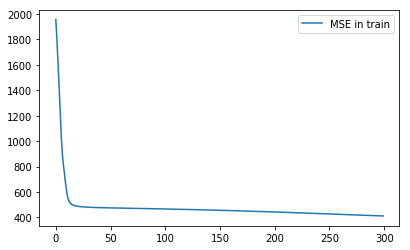

In [35]:
fig=plt.figure(figsize=(5,3))
ax=fig.add_axes([0,0,1,1])
ax.plot(range(0,300),lis,label='MSE in train')
ax.legend(loc=0)

### 实验小结

在本实验中，你对梯度的含义有了直观理解，知道了梯度是如何在网络中反向传播的，知道了它们是如何与网络的不同部分通信并控制其升高或者降低，并使得最终输出值更高的。讨论了分段计算在反向传播的实现中的重要性。应该将函数分成不同的模块，这样计算局部梯度相对容易，然后基于链式法则将其『链』起来。重要的是，不需要把这些表达式写在纸上然后演算它的完整求导公式，因为实际上并不需要关于输入变量的梯度的数学公式。只需要将表达式分成不同的可以求导的模块（模块可以是矩阵向量的乘法操作，或者取最大值操作，或者加法操作等），然后在反向传播中一步一步地计算梯度。

最后，建议观看 3Blue1Brown 制作的 [深度学习之反向传播算法视频](https://www.bilibili.com/video/BV16x411V7Qg?p=1)，获得更直观的理解。